# Predicción de Batting Average

## Carga de librerías

In [149]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, roc_auc_score
from IPython.core.display import display, HTML
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import calendar
warnings.filterwarnings('ignore')



## Lectura de datos

In [66]:
player = pd.read_csv(r"C:\Users\Playtomic\Downloads\archive (5)\player.csv")
batting = pd.read_csv(r"C:\Users\Playtomic\Downloads\archive (5)\batting.csv")
appearances = pd.read_csv(r"C:\Users\Playtomic\Downloads\archive (5)\appearances.csv")

## Análisis previo al EDA para organizar la informacion en un solo dataset

* Usaremos data par jugadores que hayan jugado entre las temporadas del 2000 y 2014
* También solo tomaremos en cuenta para el análisis temporadas donde los jugadores hayan hecho al menos 100 at bats

#### Filtrando jugadores/temporadas válid@s

In [67]:
batting1 = batting[(batting['year'] >= 2000) & (batting['year'] <= 2014)]
batting2 = batting1[batting1['ab'] > 100].copy()
batting2['bat_avg'] = batting2['h'] / batting2['ab']
batting2.shape

(6614, 23)

#### Jugadores validos

In [68]:
valid_players = batting2['player_id'].unique()
valid_players

array(['abbotje01', 'abbotku01', 'abreubo01', ..., 'vargake01',
       'vazquch01', 'wongko01'], dtype=object)

#### Adding age to batting df

In [69]:
player = player[player['player_id'].isin(valid_players)]
df_merged = pd.merge(batting2, player[['player_id', 'birth_year', 'weight',	'height', 'bats']], on = 'player_id', how='left')
df_merged['age'] = df_merged['year'] - df_merged['birth_year']
XY = df_merged
XY.shape

(6614, 28)

 __The dataset is now organized__

In [70]:
print(u' - Numero de filas del dataset:', XY.shape[0])
print(u' - Numero de columnas del dataset:', XY.shape[1])
print(u' - Nombre de las variables:', XY.columns)

 - Numero de filas del dataset: 6614
 - Numero de columnas del dataset: 28
 - Nombre de las variables: Index(['player_id', 'year', 'stint', 'team_id', 'league_id', 'g', 'ab', 'r',
       'h', 'double', 'triple', 'hr', 'rbi', 'sb', 'cs', 'bb', 'so', 'ibb',
       'hbp', 'sh', 'sf', 'g_idp', 'bat_avg', 'birth_year', 'weight', 'height',
       'bats', 'age'],
      dtype='object')


## Exploratory Data Analysis (EDA)

In [71]:
XY.dtypes

player_id      object
year            int64
stint           int64
team_id        object
league_id      object
g               int64
ab            float64
r             float64
h             float64
double        float64
triple        float64
hr            float64
rbi           float64
sb            float64
cs            float64
bb            float64
so            float64
ibb           float64
hbp           float64
sh            float64
sf            float64
g_idp         float64
bat_avg       float64
birth_year    float64
weight        float64
height        float64
bats           object
age           float64
dtype: object

Veamos la distribucion de las variables numericas para tener una noción de los datos

### Histogramas y Boxplots

In [72]:
variables_num = XY.select_dtypes(include = 'number')
variables_num.columns

Index(['year', 'stint', 'g', 'ab', 'r', 'h', 'double', 'triple', 'hr', 'rbi',
       'sb', 'cs', 'bb', 'so', 'ibb', 'hbp', 'sh', 'sf', 'g_idp', 'bat_avg',
       'birth_year', 'weight', 'height', 'age'],
      dtype='object')

Vamos a eliminar variables que no tiene mucho sentido ver su distribucion en un boxplot

In [73]:
variables_filt = variables_num.drop(columns=['age', 'height', 'weight', 'year', 'stint', 'birth_year'])

#### Boxplot

<Axes: >

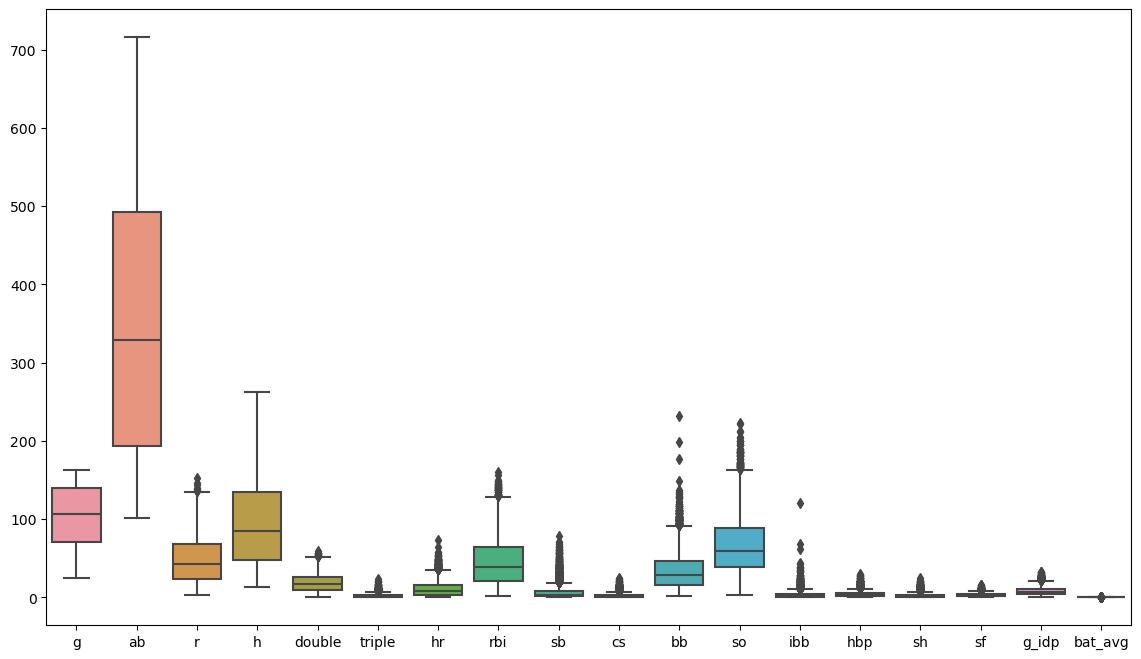

In [74]:
plt.figure(figsize=(14,8))
sns.boxplot(variables_filt)

#### Histogramas

C:\Users\Playtomic\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Playtomic\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Playtomic\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Playtomic\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

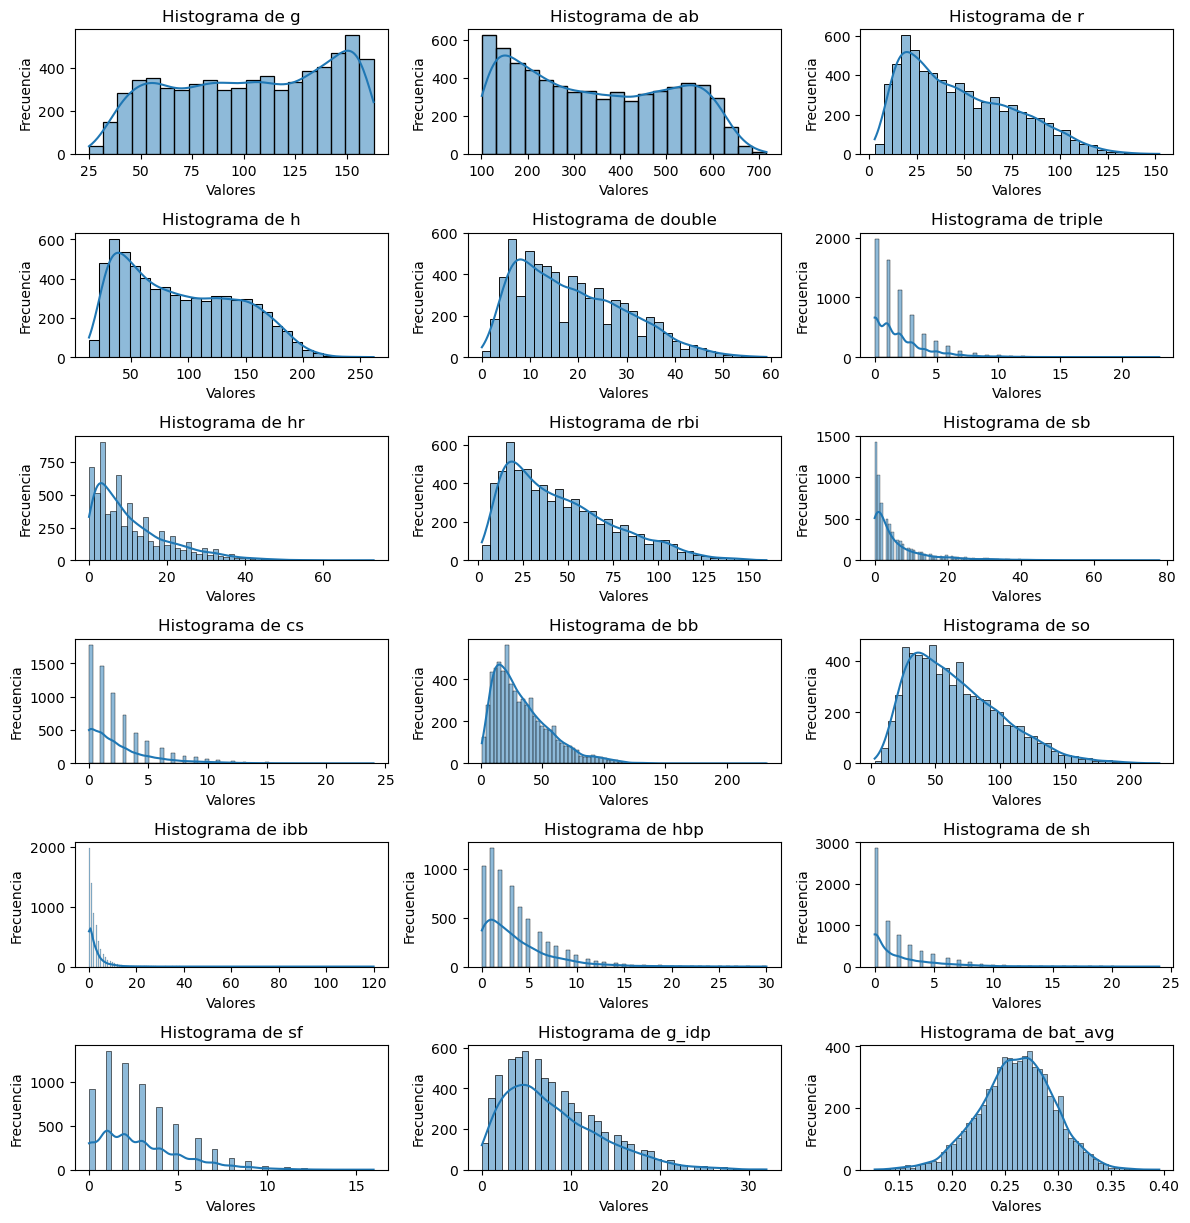

In [16]:
plt.figure(figsize=(12,18))

for i, col in enumerate(variables_filt.columns):
    plt.subplot(9, 3, i+1)
    sns.histplot(variables_filt[col], kde=True)
    plt.title(f'Histograma de {col}')
    plt.xlabel('Valores')
    plt.ylabel('Frecuencia')
    plt.tight_layout()

Se ve claramente en el histograma de __bat_avg__ como la mayoria de los jugadores promedian un 0.25 aproximadamente, y que a partir de 0.30 son pocos los jugadores que tienen estas temporadas de bateo excepcional

## Preprocesamiento de datos

### Missings:

In [18]:
XY.isnull().sum()

player_id     0
year          0
stint         0
team_id       0
league_id     0
g             0
ab            0
r             0
h             0
double        0
triple        0
hr            0
rbi           0
sb            0
cs            0
bb            0
so            0
ibb           0
hbp           0
sh            0
sf            0
g_idp         0
bat_avg       0
birth_year    0
weight        0
height        0
bats          0
age           0
dtype: int64

## Categóricas a numéricas

In [75]:
XY.select_dtypes(exclude='number').columns

Index(['player_id', 'team_id', 'league_id', 'bats'], dtype='object')

In [374]:
XY.head()

,player_id,year,stint,team_id,league_id,g,ab,r,h,double,...,hbp,sh,sf,g_idp,bat_avg,birth_year,weight,height,bats,age
0,abbotje01,2000,1,CHA,AL,80,215.0,31.0,59.0,15.0,...,2.0,2.0,1.0,2.0,0.274419,1972.0,190.0,74.0,R,28.0
1,abbotku01,2000,1,NYN,NL,79,157.0,22.0,34.0,7.0,...,1.0,0.0,1.0,2.0,0.216561,1969.0,180.0,71.0,R,31.0
2,abreubo01,2000,1,PHI,NL,154,576.0,103.0,182.0,42.0,...,1.0,0.0,3.0,12.0,0.315972,1974.0,220.0,72.0,L,26.0
3,agbaybe01,2000,1,NYN,NL,119,350.0,59.0,101.0,19.0,...,7.0,0.0,3.0,6.0,0.288571,1971.0,225.0,72.0,R,29.0
4,alexama02,2000,1,BOS,AL,101,194.0,30.0,41.0,4.0,...,0.0,2.0,0.0,0.0,0.211340,1971.0,150.0,70.0,R,29.0


In [76]:
XY = XY.drop(columns=['player_id', 'team_id'])

In [77]:
XY[:2]

,year,stint,league_id,g,ab,r,h,double,triple,hr,...,hbp,sh,sf,g_idp,bat_avg,birth_year,weight,height,bats,age
0,2000,1,AL,80,215.0,31.0,59.0,15.0,1.0,3.0,...,2.0,2.0,1.0,2.0,0.274419,1972.0,190.0,74.0,R,28.0
1,2000,1,NL,79,157.0,22.0,34.0,7.0,1.0,6.0,...,1.0,0.0,1.0,2.0,0.216561,1969.0,180.0,71.0,R,31.0


*  Incluir __player_id__ directamente como una característica podría llevar a un modelo sobreajustado. El modelo podría aprender a asociar específicamente los player_id con ciertos resultados, lo cual no generalizaría bien a jugadores no vistos durante el entrenamiento. Por lo tanto, __la eliminaremos__

* El __league_id__ __lo mantendremos__. La liga en la que juega un jugador podría ser relevante, especialmente considerando diferencias como el uso del bateador designado en la Liga Americana versus la Liga Nacional, lo que puede afectar las oportunidades de bateo y, potencialmente, el promedio de bateo.

* El __bats__ __lo mantendremos__. La mano con la que un jugador batea (derecha, izquierda, ambidiestro) puede influir en su rendimiento contra ciertos lanzadores, dado que existen ventajas conocidas en los enfrentamientos entre bateadores y lanzadores basados en la combinación de sus manos dominantes.

### league_id

In [78]:
XY.league_id.value_counts()

league_id
NL    3480
AL    3134
Name: count, dtype: int64

In [79]:
XY.league_id.dtype

dtype('O')

In [80]:
mapping = {'NL': 0, 'AL': 1} 
XY['league_id'] = XY['league_id'].map(mapping)

In [82]:
XY[:2]

,year,stint,league_id,g,ab,r,h,double,triple,hr,...,hbp,sh,sf,g_idp,bat_avg,birth_year,weight,height,bats,age
0,2000,1,1,80,215.0,31.0,59.0,15.0,1.0,3.0,...,2.0,2.0,1.0,2.0,0.274419,1972.0,190.0,74.0,R,28.0
1,2000,1,0,79,157.0,22.0,34.0,7.0,1.0,6.0,...,1.0,0.0,1.0,2.0,0.216561,1969.0,180.0,71.0,R,31.0


### Bats

In [83]:
XY.bats.value_counts()

bats
R    3516
L    2089
B    1009
Name: count, dtype: int64

In [ ]:
#Como son tres valores y si ponemo 0,1 y 2 para cada uno el modelo podria repsentar problemas, usamos one hot encoding

In [ ]:
#XY = pd.get_dummies(XY, columns=['bats'])

In [89]:
XY[['bats_R', 'bats_L', 'bats_B']] = XY[['bats_R', 'bats_L', 'bats_B']].astype(int)

In [91]:
XY[:2]

,year,stint,league_id,g,ab,r,h,double,triple,hr,...,sf,g_idp,bat_avg,birth_year,weight,height,age,bats_B,bats_L,bats_R
0,2000,1,1,80,215.0,31.0,59.0,15.0,1.0,3.0,...,1.0,2.0,0.274419,1972.0,190.0,74.0,28.0,0,0,1
1,2000,1,0,79,157.0,22.0,34.0,7.0,1.0,6.0,...,1.0,2.0,0.216561,1969.0,180.0,71.0,31.0,0,0,1


## bat_avg transformada a dummy

* La eleccion del umbral para definir las clases en __bat_avg__ es muy importante para obtener una distribución equilibrada de datos entre aquellos por encima y por debajo del batting average.
* Un modelo con clases desequilibradas puede desarrollar un sesgo hacia la clase más frecuente, lo que puede resultar en una capacidad predictiva pobre para la clase menos frecuente.
* La mayoría de los jugadores tienen un promedio de bateo por debajo de .300, por lo tanto, ajustar el umbral para acercarse a una distribución 50/50 ayudará a mejorar el aprendizaje y la generalización del modelo.

In [92]:
temporadas_por_encima = (XY['bat_avg'] > 0.265).sum()
temporadas_por_debajo = (XY['bat_avg'] <= 0.265).sum()

In [93]:
print(temporadas_por_encima, temporadas_por_debajo)

3115 3499


Con un umbral diferenciador de clases de __0.265__ tenemos los datos suficientemente balanceados y sigue siendo un umbral de relevancia en nuestro contexto de beisbol, por lo tanto, entrenaremos nuestro modelo con este mismo

In [95]:
XY['bat_avg'] = (XY['bat_avg'] > 0.265).astype(int)
XY.head()

,year,stint,league_id,g,ab,r,h,double,triple,hr,...,sf,g_idp,bat_avg,birth_year,weight,height,age,bats_B,bats_L,bats_R
0,2000,1,1,80,215.0,31.0,59.0,15.0,1.0,3.0,...,1.0,2.0,1,1972.0,190.0,74.0,28.0,0,0,1
1,2000,1,0,79,157.0,22.0,34.0,7.0,1.0,6.0,...,1.0,2.0,0,1969.0,180.0,71.0,31.0,0,0,1
2,2000,1,0,154,576.0,103.0,182.0,42.0,10.0,25.0,...,3.0,12.0,1,1974.0,220.0,72.0,26.0,0,1,0
3,2000,1,0,119,350.0,59.0,101.0,19.0,1.0,15.0,...,3.0,6.0,1,1971.0,225.0,72.0,29.0,0,0,1
4,2000,1,1,101,194.0,30.0,41.0,4.0,3.0,4.0,...,0.0,0.0,0,1971.0,150.0,70.0,29.0,0,0,1


## Comprobación tipos no numéricos:

In [96]:
XY.select_dtypes(exclude=['number']).columns

Index([], dtype='object')

### Matriz de correlacion incial

A partir de ella podremos ir eliminando variables una a una que estan correladas por encima de 0.80 o por debajo de -0.80

Text(0.5, 1.0, 'Matriz de correlaciones de Pearson')

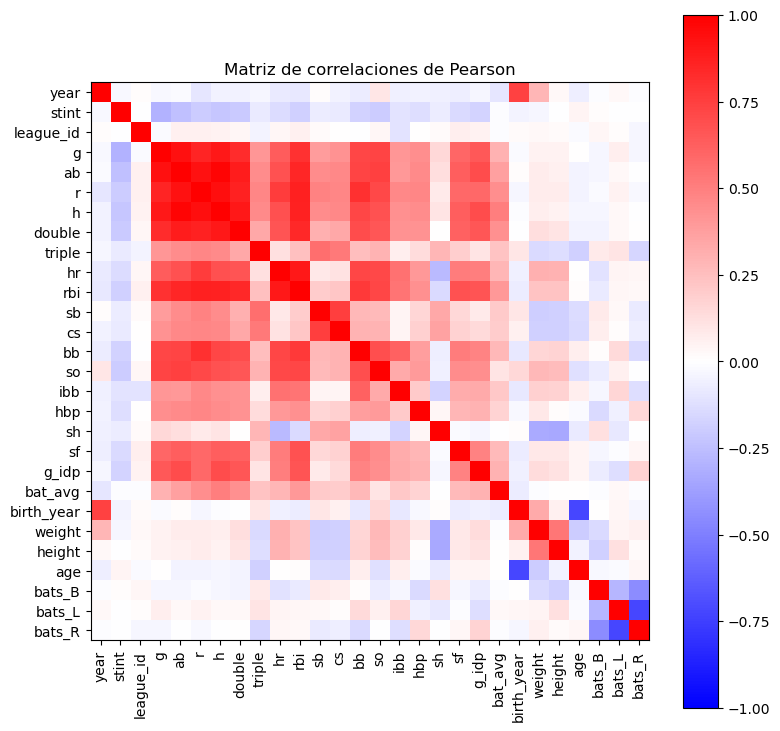

In [97]:
matriz_correlaciones = XY.corr(method='pearson')
n_ticks = len(XY.columns)
plt.figure( figsize=(9, 9) )
plt.xticks(range(n_ticks), XY.columns, rotation='vertical')
plt.yticks(range(n_ticks), XY.columns)
plt.colorbar(plt.imshow(matriz_correlaciones, interpolation='nearest', 
                            vmin=-1., vmax=1., 
                            cmap=plt.get_cmap('bwr')))
plt.title('Matriz de correlaciones de Pearson')

In [286]:
matriz_correlaciones

,year,stint,g,ab,r,h,double,triple,hr,rbi,...,ibb,hbp,sh,sf,g_idp,bat_avg,birth_year,weight,height,age
year,1.000000,-0.016588,-0.026773,-0.016216,-0.098998,-0.048198,-0.055223,-0.024139,-0.073995,-0.093360,...,-0.068240,-0.053167,-0.074459,-0.065432,-0.031952,-0.088100,0.763056,0.277189,0.033498,-0.072996
stint,-0.016588,1.000000,-0.302930,-0.244342,-0.201269,-0.221353,-0.207203,-0.086751,-0.137396,-0.184525,...,-0.102777,-0.128436,-0.073711,-0.142503,-0.171180,0.015121,-0.044962,-0.031001,-0.008976,0.051058
g,-0.026773,-0.302930,1.000000,0.935450,0.854143,0.900894,0.821971,0.406513,0.634943,0.799862,...,0.407646,0.442932,0.153567,0.596886,0.650553,0.151455,-0.017547,0.046920,0.048947,-0.002494
ab,-0.016216,-0.244342,0.935450,1.000000,0.921721,0.976520,0.886198,0.442779,0.674231,0.850460,...,0.401857,0.457623,0.129713,0.629080,0.700163,0.203471,0.015404,0.072999,0.055400,-0.041679
r,-0.098998,-0.201269,0.854143,0.921721,1.000000,0.938546,0.863998,0.465615,0.761962,0.869504,...,0.462769,0.474717,0.078827,0.593509,0.591820,0.310992,-0.040658,0.064126,0.070651,-0.046600
h,-0.048198,-0.221353,0.900894,0.976520,0.938546,1.000000,0.904156,0.452684,0.677742,0.863311,...,0.437594,0.448513,0.105817,0.625682,0.694827,0.338453,-0.009237,0.062432,0.052203,-0.038979
double,-0.055223,-0.207203,0.821971,0.886198,0.863998,0.904156,1.000000,0.337199,0.670422,0.840179,...,0.431026,0.424118,0.003184,0.614228,0.653833,0.301117,-0.012036,0.119838,0.100323,-0.042418
triple,-0.024139,-0.086751,0.406513,0.442779,0.465615,0.452684,0.337199,1.000000,0.119713,0.245764,...,0.059911,0.134178,0.277847,0.187918,0.105495,0.126867,0.101593,-0.152763,-0.127367,-0.183426
hr,-0.073995,-0.137396,0.634943,0.674231,0.761962,0.677742,0.670422,0.119713,1.000000,0.898067,...,0.552352,0.401277,-0.265625,0.515643,0.500692,0.237592,-0.056509,0.303644,0.299306,0.005474
rbi,-0.093360,-0.184525,0.799862,0.850460,0.869504,0.863311,0.840179,0.245764,0.898067,1.000000,...,0.543629,0.437598,-0.141460,0.678720,0.664720,0.291063,-0.072855,0.226338,0.225157,0.009308


# Eliminacion para controlar la multicolinealidad

Text(0.5, 1.0, 'Matriz de correlaciones de Pearson')

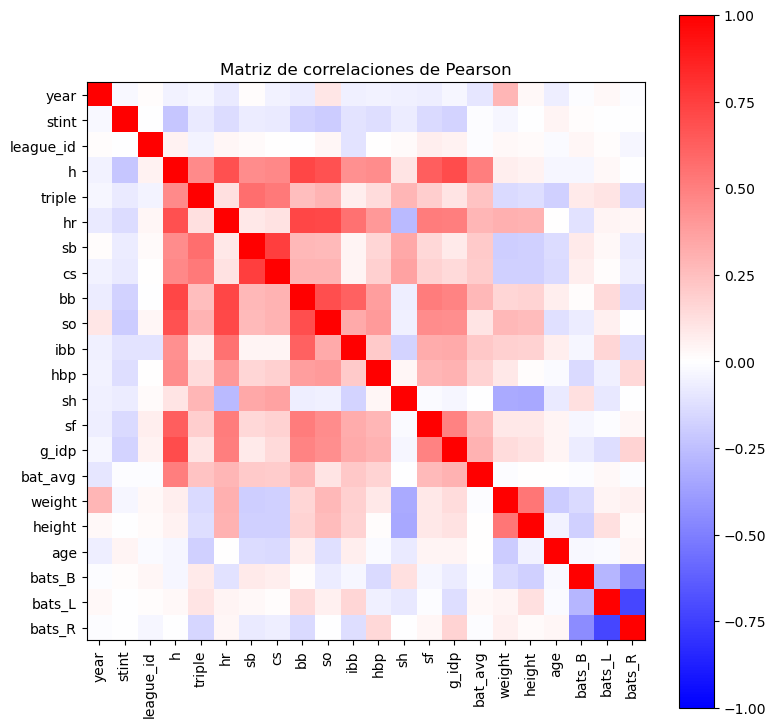

In [110]:
matriz_correlaciones = XY.corr(method='pearson')
n_ticks = len(XY.columns)
plt.figure( figsize=(9, 9) )
plt.xticks(range(n_ticks), XY.columns, rotation='vertical')
plt.yticks(range(n_ticks), XY.columns)
plt.colorbar(plt.imshow(matriz_correlaciones, interpolation='nearest', 
                            vmin=-1., vmax=1., 
                            cmap=plt.get_cmap('bwr')))
plt.title('Matriz de correlaciones de Pearson')

In [102]:
matriz_correlaciones

,year,stint,league_id,g,ab,r,h,double,triple,hr,...,sh,sf,g_idp,bat_avg,weight,height,age,bats_B,bats_L,bats_R
year,1.000000,-0.024245,0.011924,-0.028846,-0.016682,-0.097254,-0.047507,-0.052058,-0.031326,-0.080918,...,-0.059541,-0.063863,-0.035276,-0.100884,0.281969,0.027823,-0.068018,-0.015246,0.027734,-0.014851
stint,-0.024245,1.000000,-0.003370,-0.301090,-0.242747,-0.199479,-0.219802,-0.206901,-0.084767,-0.137695,...,-0.072914,-0.140989,-0.170289,-0.011809,-0.036424,-0.005894,0.044338,0.010562,-0.001069,-0.006614
league_id,0.011924,-0.003370,1.000000,-0.016648,0.059458,0.057013,0.049512,0.034928,-0.039761,0.032973,...,0.023100,0.064786,0.049539,-0.007900,0.030426,0.016590,-0.018310,0.036964,0.010514,-0.036429
g,-0.028846,-0.301090,-0.016648,1.000000,0.935056,0.854822,0.901061,0.822250,0.408029,0.636622,...,0.155027,0.596653,0.651062,0.300035,0.051417,0.051110,0.000053,-0.035767,0.067725,-0.037318
ab,-0.016682,-0.242747,0.059458,0.935056,1.000000,0.922419,0.976611,0.886680,0.446094,0.675685,...,0.132708,0.627877,0.701010,0.368098,0.077164,0.056919,-0.040423,-0.032618,0.025874,-0.000600
r,-0.097254,-0.199479,0.057013,0.854822,0.922419,1.000000,0.939269,0.863731,0.469161,0.763082,...,0.079692,0.592642,0.592824,0.442490,0.070336,0.072942,-0.045773,-0.023360,0.050390,-0.030109
h,-0.047507,-0.219802,0.049512,0.901061,0.976611,0.939269,1.000000,0.904552,0.455708,0.680292,...,0.108042,0.625414,0.695895,0.500281,0.067332,0.054125,-0.036980,-0.031904,0.028272,-0.003349
double,-0.052058,-0.206901,0.034928,0.822250,0.886680,0.863731,0.904552,1.000000,0.339025,0.671586,...,0.003754,0.612707,0.656469,0.437133,0.126862,0.103043,-0.042362,-0.040391,0.026924,0.004023
triple,-0.031326,-0.084767,-0.039761,0.408029,0.446094,0.469161,0.455708,0.339025,1.000000,0.123161,...,0.281810,0.188382,0.107924,0.234053,-0.146552,-0.126615,-0.179795,0.082519,0.104669,-0.156965
hr,-0.080918,-0.137695,0.032973,0.636622,0.675685,0.763082,0.680292,0.671586,0.123161,1.000000,...,-0.266095,0.514540,0.502712,0.285362,0.305069,0.302632,0.004691,-0.109754,0.044051,0.038048


In [98]:
#Eliminamos birth year
XY = XY.drop(columns=['birth_year'])

In [104]:
#Eliminamos double
XY = XY.drop(columns=['double'])

In [105]:
#Eliminamos rbi
XY = XY.drop(columns=['rbi'])

In [106]:
#Eliminamos r
XY = XY.drop(columns=['r'])

In [107]:
#Eliminamos ab
XY = XY.drop(columns=['ab'])

In [109]:
#Eliminamos g
XY = XY.drop(columns=['g'])

## Division en features X + target Y

In [111]:
X = XY.drop(columns=['bat_avg'])
Y = XY['bat_avg']

### Estadarización de datos previa

In [116]:
obj_escalar = StandardScaler()
X_estandarizado = obj_escalar.fit_transform(X)

### División en train y test:

In [119]:
X_train, X_test, Y_train, Y_test = train_test_split(X_estandarizado, Y, test_size = 0.2, random_state=0)

# Aplicamos un modelo de regresión logística

In [126]:
modelo = LogisticRegression()
parametros = {"C": [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09], 
              "class_weight":['balanced', None]}
#C: Este parámetro controla la fuerza de regularización. Valores más pequeños especifican una regularización más fuerte. En mi caso, estoy probando varios valores desde 0. hasta 0.09 en incrementos de 0.01.
#class_weight: Este parámetro se utiliza para manejar el desequilibrio de clases. 
#'balanced' indica que el modelo ajustará automáticamente los pesos de clase de manera inversamente proporcional al número de muestras en cada clase. 
#None significa que no se aplicará ningún peso de clase. Esto es porque ya nosotros mismos tenemos el dataset balanceado

Con GridSearchCV se realiza una optimización. Esta función lo que hace es ajustar el modelo que se pasa como argumento con todas las combinaciones posibles de los parámetros. En este caso, todas las combinaciones de C y class_weights.

In [127]:
modelo_gs = GridSearchCV(modelo, param_grid=parametros, cv = 5, scoring='roc_auc')
modelo_gs.fit(X_train, Y_train)
# modelo_gs: Aquí están creando una nueva instancia de GridSearchCV llamada modelo_gs.

# modelo: El modelo base que están utilizando, en este caso, es una regresión logística (LogisticRegression).
# parametros: El diccionario que contiene las combinaciones de hiperparámetros que se probarán, como se definió previamente.
# cv=5: Se utiliza validación cruzada con 5 folds. Cada combinación de hiperparámetros se evaluará utilizando este esquema de validación cruzada.
# scoring='roc_auc': Este parámetro indica que la métrica a optimizar durante la búsqueda de hiperparámetros es el área bajo la curva ROC (ROC AUC). 
# La curva ROC y su área bajo la curva (AUC) son métricas comúnmente utilizadas para evaluar el rendimiento de modelos de clasificación binaria.
# fit(X_train, Y_train): Finalmente, se ajusta el modelo de búsqueda de hiperparámetros utilizando los datos de entrenamiento (X_train, Y_train).

C:\Users\Playtomic\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Playtomic\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Playtomic\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1160, in fit
    self._validate_params()
  File "C:\Users\Playtomic\anaconda3\Lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Playtomi

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,
                               0.08, 0.09],
                         'class_weight': ['balanced', None]},
             scoring='roc_auc')

In [128]:
print(modelo_gs.best_params_, "\nROC AUC: {}".format(round(modelo_gs.best_score_,2)))

{'C': 0.09, 'class_weight': 'balanced'} 
ROC AUC: 0.88


In [130]:
df_search = pd.DataFrame.from_dict(modelo_gs.cv_results_)

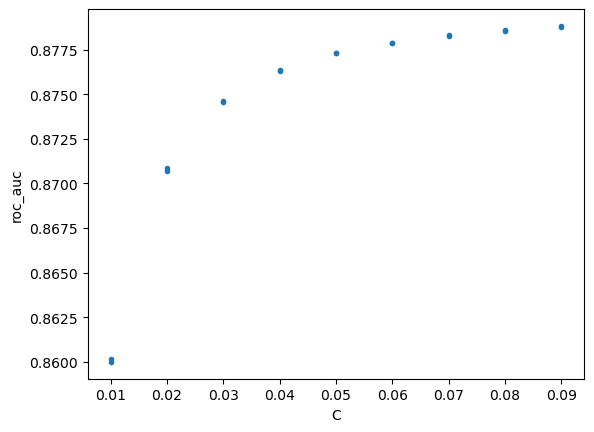

In [131]:
plt.xlabel('C')
plt.ylabel('roc_auc')
plt.plot( df_search['param_C'], df_search['mean_test_score'], '.')
#Vemos como el ROC_AUC va mejorando a medida que aumenta C hasta llegar al optimo

## Analizamos el modelo con el mejor alpha

En este paso nos quedamos con los mejores parámetros obtenidos en el paso anterior:

In [132]:
reg_log = LogisticRegression(C=modelo_gs.best_params_['C'], class_weight=modelo_gs.best_params_['class_weight'])

In [133]:
reg_log.fit(X_train, Y_train)
#Durante este paso, el modelo aprende la relación entre las características (variables independientes) y la variable objetivo (variable dependiente).

LogisticRegression(C=0.09, class_weight='balanced')

Ya tenemos el modelo elegido y optimizado, ahora comparamos con el conjunto Test

Queremos hacer predicciones sobre nuevos datos que el modelo no ha visto, por esto usaremos X_test.

In [134]:
y_test_pred_prob = reg_log.predict_proba(X_test) #Cada fila de esta matriz representa una instancia en X_test, y las dos columnas corresponden 
# a las probabilidades predichas para las clases "por debajo del bat_avg (Clase 0)" (columna 0) y la otra lo contrario

In [135]:
y_test_pred_prob

array([[0.52464375, 0.47535625],
       [0.25022127, 0.74977873],
       [0.71355372, 0.28644628],
       ...,
       [0.49075735, 0.50924265],
       [0.02636021, 0.97363979],
       [0.9006354 , 0.0993646 ]])

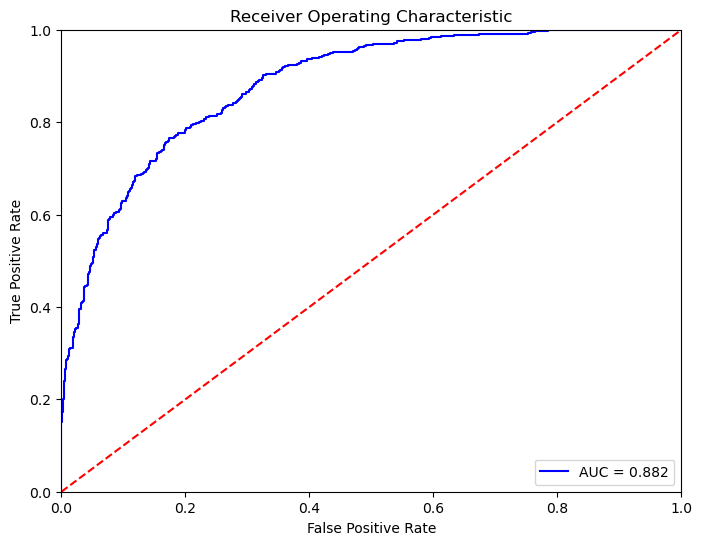

In [150]:
preds = y_test_pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Umbralizo las predicciones:

Debemos poner un umbral para determinar a partir de que cantidad de probabilidad una instancia será considerada como probabilidad suficiente para que entré como predicción final que este jugador en X temporada tendría un bat_avg por encima o por debajo de 0.265

El umbral a utilizar será el que maximice el área bajo la curva ROC (AUC).

Para calcular el umbral que maximiza el área bajo la curva ROC (AUC), utilizaré el método del punto de operación óptimo (Optimal Operating Point - OOP). Este método implica encontrar el umbral que maximiza la suma de la sensibilidad y la especificidad.

In [151]:
# Calculo la curva ROC
fpr, tpr, umbrales = roc_curve(Y_test, preds) #fpr: false positive rate, tpr:true positive rate, y los umbrales utilizados para calcular estos rates

# Calculo el AUC máximo
auc_maximo = roc_auc_score(Y_test, preds)

# Encontramos el índice del umbral que maximiza la suma de sensibilidad y especificidad
umbral_optimo_idx = np.argmax(tpr - fpr)

# Obtenenemos el umbral óptimo
umbral_optimo = umbrales[umbral_optimo_idx]

print('AUC máximo:', auc_maximo)
print('Umbral óptimo:', umbral_optimo)

AUC máximo: 0.8819535114658233
Umbral óptimo: 0.47535624687792605


In [152]:
umbral = umbral_optimo
y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)

In [153]:
print(u"Matriz de confusión\n", metrics.confusion_matrix(Y_test, y_umbralizadas))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))  
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2))) 

Matriz de confusión
 [[588 124]
 [144 467]]

Accuracy	0.8
Sensitividad	0.76
Precisión	0.79


### Matriz de Confusión
La matriz de confusión nos proporciona una visión clara de las predicciones correctas e incorrectas del modelo, distribuidas de la siguiente manera:

* Verdaderos Negativos (588): El modelo predijo acertadamente 588 veces que jugadores no superarían el promedio de bateo de 0.265.
* Falsos Positivos (124): En 124 ocasiones, el modelo predijo erróneamente que jugadores superarían el umbral de 0.265 cuando no lo hicieron.
* Falsos Negativos (144): El modelo falló al predecir que 144 temporadas estarían por debajo del umbral de 0.265 cuando en realidad lo superaron.
* Verdaderos Positivos (467): Finalmente, el modelo acertó en 467 casos al prever que las temporadas superarían el promedio de bateo de 0.265.

### Métricas de Rendimiento
* Exactitud (Accuracy) del 80%: Esta métrica nos indica que, en general, el modelo es capaz de predecir correctamente el 80% de las veces si una temporada de un jugador superará o no el promedio de bateo de 0.265. Es una buena medida para tener una idea general del rendimiento del modelo, pero no nos dice todo sobre su capacidad para distinguir entre las clases de interés.
  
* Sensibilidad (Recall) del 76%: Esta métrica señala que el modelo tiene una capacidad del 76% para identificar correctamente todas las temporadas relevantes que superan el umbral de 0.265. Es especialmente importante cuando queremos minimizar los falsos negativos.

* Precisión del 79%: Indica que, de todas las temporadas que el modelo predijo que superarían el umbral de 0.265, el 79% efectivamente lo hizo. Esta métrica es crucial cuando el costo de un falso positivo es alto.
Área Bajo la Curva ROC (AUC) y Umbral Óptimo

* AUC de 0.882: El AUC nos ayuda a entender la capacidad del modelo para diferenciar entre las clases (temporadas por encima y por debajo de 0.265). Un AUC de 0.882 es excelente, indicando un alto grado de separabilidad entre las clases.

* Umbral Óptimo de 0.475: Este umbral es el punto de corte para clasificar una temporada como superando el promedio de bateo de 0.265. Fue seleccionado para optimizar la combinación de precisión y sensibilidad, lo que nos permite ajustar el balance entre los falsos positivos y falsos negativos según nuestras necesidades específicas.

### Conclusión
Los resultados obtenidos demuestran que nuestro modelo de regresión logística es bastante efectivo y robusto para predecir el rendimiento de bateo de los jugadores en diferentes temporadas. Las métricas seleccionadas, junto con el análisis detallado de la matriz de confusión y el AUC, nos proporcionan una comprensión profunda de las fortalezas y limitaciones de nuestro modelo. Esto nos posiciona bien para hacer recomendaciones basadas en datos sobre jugadores potencialmente exitosos, así como para ajustar nuestras estrategias y enfoques de entrenamiento para mejorar aún más el rendimiento del modelo en el futuro.